In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
from nbi1 import *

import warnings
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines



warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    

In [3]:
state_1 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_1", index_col = 0)
state_2 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_2", index_col = 0)
state_3 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_3", index_col = 0)
state_4 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_4", index_col = 0)
state_5 = pd.read_csv("03-09-19-thesis-dataset-without-outliers_states_5", index_col = 0)

In [4]:
df_wo = pd.concat([state_1,state_2,state_3,state_4,state_5])

In [5]:
df_wo.shape

(828726, 24)

In [5]:
# Arrange Dataframe is ascending order
df_wo['5 percent'] = pd.qcut(df_wo['Avg. Daily Precipitation'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])
df_wo['spanlength'] = pd.qcut(df_wo['Length Of Maximum Span Flat'],[0, .1, .8, 1.], labels = ['Very Low','Medium','Very High'])

df_anova = df_wo[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code','5 percent',\
                       'Length Of Maximum Span Flat', 'Material','Structure Type', 'Maintainer','spanlength']]

df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "5 percent": "precipitation", \
                                               "Length Of Maximum Span Flat": "lengthofspan",\
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               "spanlength":"spanlength"
                                              })
# Northeast
N = ['09','23','25','33','44','50','34','36','42']  

# Midwest
M = ['17','18','21','39','55','19','20','27','29','31','38','46']

# South
S = ['10','12','13','24','37','45','51','11','54','01','21','28','47','05','22','40','48']

# West
W = ['04','08','16','32','30','35','49','56','01','06','15','41','53','72']

w = [int(i) for i in W]
s = [int(i) for i in S]
m = [int(i) for i in M]
n = [int(i) for i in N]

west_df_anova = df_anova[df_anova["region"].isin(w)]
west_df_anova['region'] = len(west_df_anova)*['West']

south_df_anova = df_anova[df_anova["region"].isin(s)]
south_df_anova['region'] = len(south_df_anova)*['South']

midwest_df_anova = df_anova[df_anova["region"].isin(m)]
midwest_df_anova['region'] = len(midwest_df_anova)*['Midwest']

northeast_df_anova = df_anova[df_anova["region"].isin(n)]
northeast_df_anova['region'] = len(northeast_df_anova)*['Northeast']



df_anova['precp']  =  pd.qcut(df_anova['precp'], 4, labels=["Very Light", "Light", "Moderate","Heavy"])

df_anova = pd.concat([west_df_anova,midwest_df_anova,south_df_anova,northeast_df_anova])

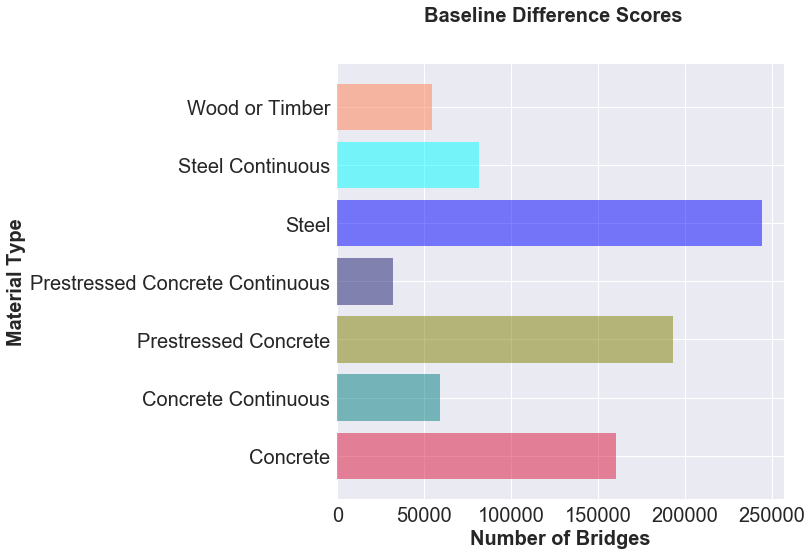

In [22]:
count_mat = material.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = [ "Concrete", "Concrete Continuous", "Prestressed Concrete",\
         "Prestressed Concrete Continuous", "Steel", "Steel Continuous", "Wood or Timber"]


no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal','olive','midnightblue','blue','cyan','coral','magenta'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()


In [18]:
count_mat

materialname
Concrete                           160314
Concrete Continuous                 58874
Prestressed Concrete               193321
Prestressed Concrete Continuous     32026
Steel                              244463
Steel Continuous                    81461
Wood or Timber                      54275
Name: score, dtype: int64

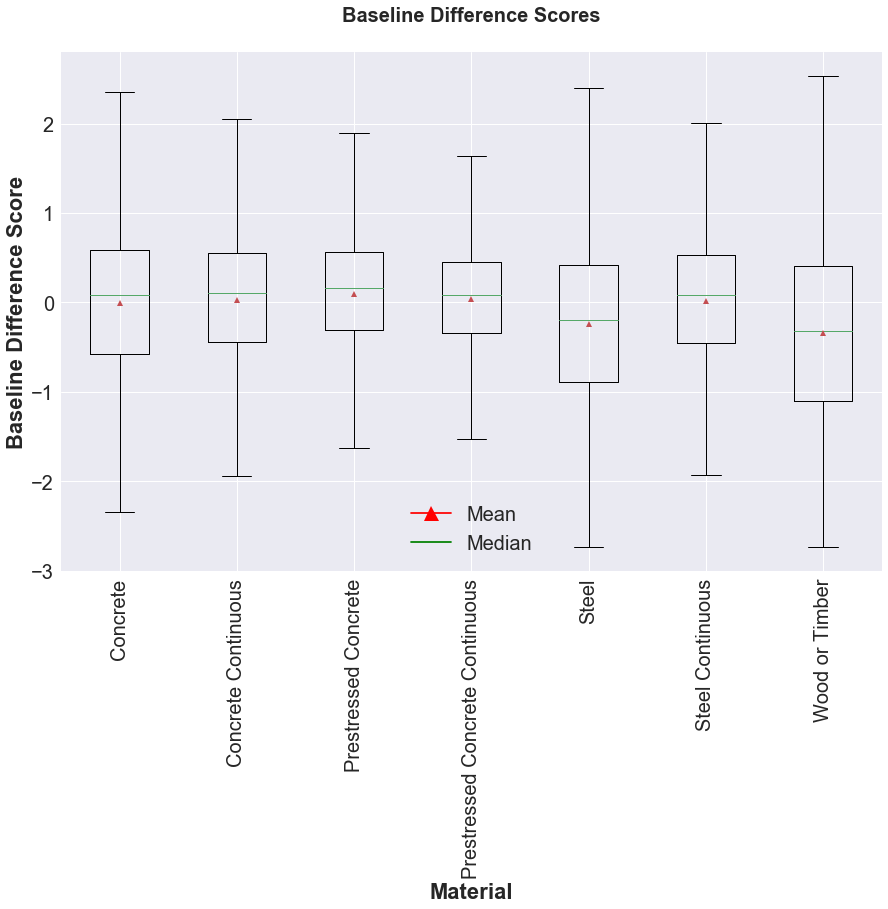

In [23]:
## Midwest, Northeast, South, West
scores_mat2 = material[material['materialname'] == 'Concrete']['score']
scores_mat3 = material[material['materialname'] == 'Concrete Continuous']['score']

scores_mat5 = material[material['materialname'] == 'Prestressed Concrete']['score']
scores_mat6 = material[material['materialname'] == 'Prestressed Concrete Continuous']['score']

scores_mat7 = material[material['materialname'] == 'Steel']['score']
scores_mat8 = material[material['materialname'] == 'Steel Continuous']['score']
scores_mat9 = material[material['materialname'] == 'Wood or Timber']['score']

scores_mat = [scores_mat2, scores_mat3, scores_mat5, scores_mat6, scores_mat7, scores_mat8, scores_mat9]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')




# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_mat, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 90)
plt.yticks(size = 20)
plt.xlabel("Material", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

#### ANOVA - Small Sample

In [12]:
material = df_anova[~df_anova['material'].isin([0,-1])]
material['materialname'] = retMaterialNames(material['material'])
material = material[~material['materialname'].isin(['Aluminum, Wrought Iron, or Cast Iron','Masonry'])]
mat= material.groupby('materialname').apply(lambda s: s.sample(100))['materialname'].tolist()
score = material.groupby('materialname').apply(lambda s: s.sample(100))['score'].tolist()
df_mat_sample_100 = pd.DataFrame({'materialname':mat, 'score':score})
formula = 'score ~ C(materialname)'
mat_undersample = undersample(df_mat_sample_100, 'materialname')
aov(mat_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(materialname),11.872406,6.0,2.807495,0.010487,0.02373,0.015256
Residual,488.429297,693.0,NaN,NaN,NaN,NaN


#### ANOVA - Large Sample

In [14]:
formula = 'score ~ C(materialname)'
mat_undersample = undersample(material, 'material')
aov(mat_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(materialname),5368.917000,6.0,1259.899323,0.0,0.032621,0.032595
Residual,159216.024472,224175.0,NaN,NaN,NaN,NaN


## Structure Type

To test compound effect on the condition of the bridges, one of the factors to test is Material with structure type of the bridges, Since Material and Type of structure is a part of the overall structure.

In [42]:
structureType = {
         1  : "Slab",
         2  : "Stringer / Multi-beam or Girder",
         3  : "Girder and Floorbeam System",
         4  : "Tee Beam",
         5  : "Box Beam or Girders - Multiple",
         6  : "Box Beam or Girders - Single or Spread",
         7  : "Frame (except frame culverts)",
         8  : "Orthotropic",
         9  : "Truss - Deck",
         10 : "Truss - Thru",
         11 : "Arch - Deck",
         12 : "Suspension",
         13 : "Stayed Girder",
         14 : "Movable - Lift",
         15 : "Movable - Bascule",
         16 : "Movable - Swing",
         17 : "Tunnel",
         18 : "Culvert (includes frame culverts)",
         19 : "Mixed types",
         20 : "Segmental Box Girder",
         21 : "Channel Beam",
         22 : "Other"
        }


df_anova['structuretypename'] = df_anova['structuretype'].map(structureType)

st_type = pd.DataFrame(df_anova.groupby('structuretypename')['score'].count()).sort_values(by='score', ascending = False)

### Count

In [43]:
st_type

,score
structuretypename,
Stringer / Multi-beam or Girder,457432
Slab,127949
Box Beam or Girders - Multiple,75001
Tee Beam,62381
Truss - Thru,27795
Girder and Floorbeam System,16458
Box Beam or Girders - Single or Spread,15669
Other,14047
Frame (except frame culverts),10984


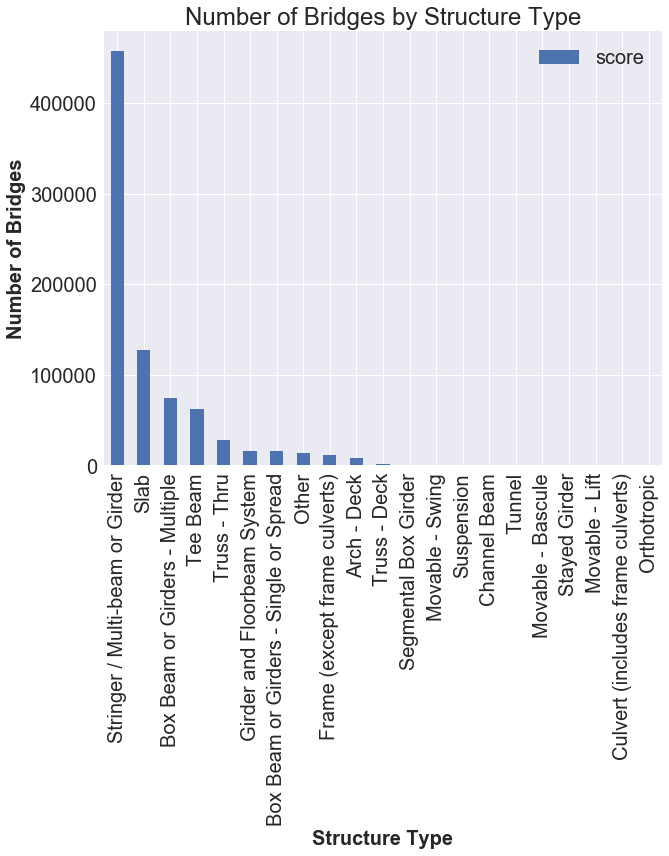

In [54]:
st_type.plot.bar(figsize=(10,8))
plt.title("Number of Bridges by Structure Type")
plt.xlabel("Structure Type", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Structure Type  - Analysis.
We selected the most common structure type used in construction of bridges.
1. Stringer / Multi-bean  or Girder
2. Slab
3. Box Beam or Girder - Multiple
4. Tee Beam

One of the drawback of these analysis is that, we are analysis only the most common type of structures, which is at the moment limited to top 4 mostly used structure type.

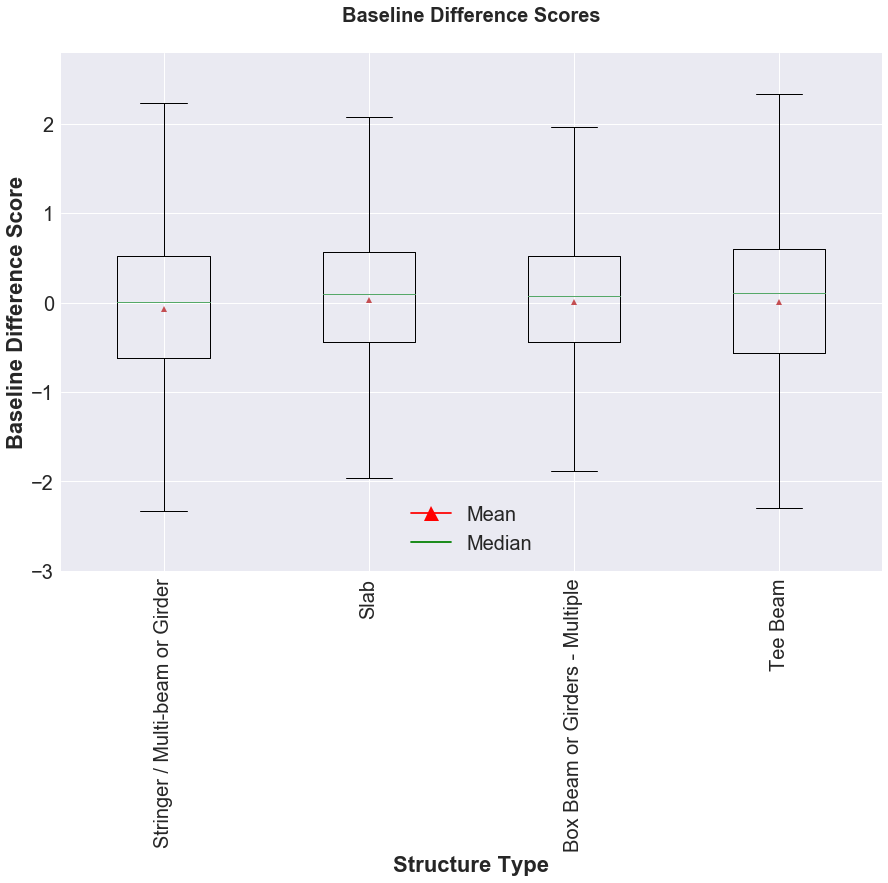

In [99]:
## Midwest, Northeast, South, West
scores_st1 =  stype[stype['structuretypename'] == 'Stringer / Multi-beam or Girder']['score']
scores_st2 = stype[stype['structuretypename'] == 'Slab']['score']

scores_st3 = stype[stype['structuretypename'] == 'Box Beam or Girders - Multiple']['score']
scores_st4 = stype[stype['structuretypename'] == 'Tee Beam']['score']



scores_st = [scores_st1, scores_st2, scores_st3, scores_st4]


# green_line = mlines.Line2D([], [], color='Green',
#                           markersize=15, label='Median')
# red_triangle = mlines.Line2D([], [], color='Red', marker='^',
#                           markersize=15, label='Mean')



labels = ['Stringer / Multi-beam or Girder', 'Slab', 'Box Beam or Girders - Multiple','Tee Beam']
# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Baseline Difference Scores", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_st, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 90)
plt.yticks(size = 20)
plt.xlabel("Structure Type", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

#### ANOVA - Small Sample

In [84]:
stype = df_anova[~df_anova['structuretype'].isin([0,-1])]
stype['structuretypename'] = stype['structuretype'].map(structureType)
stype = stype[stype['structuretypename'].isin(['Stringer / Multi-beam or Girder','Slab','Box Beam or Girders - Multiple', 'Tee Beam'])]

st = stype.groupby('structuretypename').apply(lambda s: s.sample(100))['structuretypename'].tolist()
score = stype.groupby('structuretypename').apply(lambda s: s.sample(100))['score'].tolist()
df_st_sample_100 = pd.DataFrame({'structuretype':st, 'score':score})
formula = 'score ~ C(structuretype)'
st_undersample = undersample(df_st_sample_100, 'structuretype')
aov(st_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(structuretype),1.161928,3.0,0.552868,0.646485,0.004171,-0.003365
Residual,277.416196,396.0,NaN,NaN,NaN,NaN


#### ANOVA - Large Sample

In [85]:
formula = 'score ~ C(structuretypename)'
stype_undersample = undersample(stype, 'material')
aov(stype_undersample, formula)




,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(structuretypename),3.778509,3.0,1.345738,0.260331,0.017474,0.00447
Residual,212.453839,227.0,NaN,NaN,NaN,NaN
